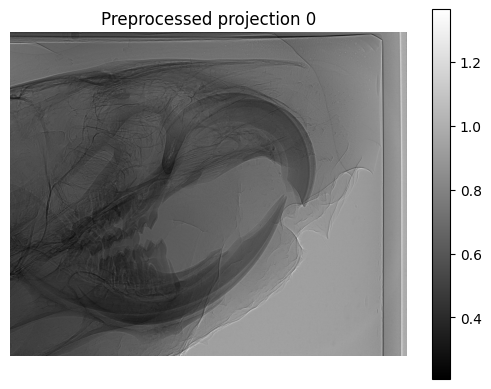

In [13]:
import numpy as np

def display_slice(slice, title='Slice', cmap='gray', vmin=None, vmax=None, colorbar=False):
    """
    Display a slice with matplotlib dans un 1:1 aspect ratio

    Parameters
    ----------
    slice : numpy array
        Slice to display
    title : str
        Title of the plot
    cmap : str
        Color map to use

    Returns
    -------
    None
    
    """
    import matplotlib.pyplot as plt

    plt.imshow(slice, cmap=cmap, vmin=vmin, vmax=vmax)

    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')

    if colorbar:
        plt.colorbar()
        
    plt.title(title)

    plt.show()

projs = np.load('mbd_projs.npy')

display_slice(projs[0], title='Preprocessed projection 0', cmap='gray', colorbar=True)

Processing projections: 100%|██████████| 3200/3200 [01:29<00:00, 35.75it/s]


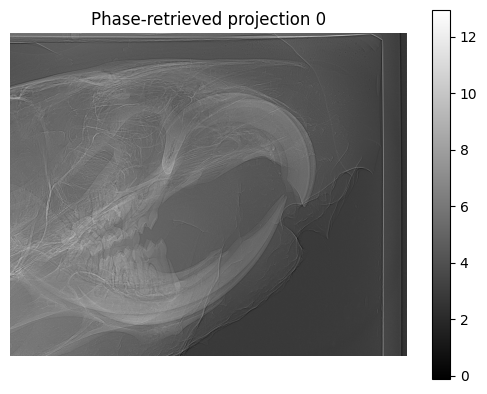

SNR = 10.918320417404175


In [14]:
import numpy as np
import cupy as cp
from cupy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq
import math
from tqdm import tqdm
import napari
import matplotlib.pyplot as plt
from cupyx.scipy.ndimage import gaussian_filter



def keVtoLambda(energy_kev):
    """
    Convert energy in keV to wavelength in m.

    Parameters
    ----------
    energy_kev : float
        Energy in keV

    Returns
    -------
    float
        Wavelength in m
    """
    h = 6.58211928e-19  # Planck constant in keV·s
    c = 299792458       # Speed of light in m/s
    return h * c / energy_kev

def phase_retrieval(I, delta_beta, dist_obj_detector, energy_kev, pixel_size):
    """
    Apply phase retrieval according to formula (6) from Weitkamp et al. (2011).

    Parameters
    ----------
    I : cupy.ndarray
        Measured intensity image.
    delta_beta : float
        Beta/delta ratio.
    dist_obj_detector : float
        Propagation distance (m).
    energy_kev : float
        X-ray energy (keV).
    pixel_size : float
        Detector pixel size (m).

    Returns
    -------
    phi : numpy.ndarray
        Reconstructed phase map.
    """
    wavelength = keVtoLambda(energy_kev)
    ny, nx = I.shape

    # Spatial frequencies
    u = fftfreq(nx, d=pixel_size)
    v = fftfreq(ny, d=pixel_size)
    U, V = cp.meshgrid(u, v, indexing='ij')

    # Fourier transform of the image
    I_fft = fftshift(fft2(I))

    # Compute filter
    denominator = 1 + cp.pi * wavelength * dist_obj_detector * delta_beta * (U**2 + V**2)
    denominator[denominator == 0] = cp.finfo(float).eps  # Avoid division by zero

    # Apply filter and inverse FFT
    phi_fft = I_fft / denominator
    phi = - cp.log(cp.maximum(cp.real(ifft2(ifftshift(phi_fft))), cp.finfo(cp.float32).eps)) * delta_beta * 0.5

    return phi

def get_padding_size(image, energy, effective_pixel_size, distance):
    """
    Calculate the padding size for a 2D image.

    Parameters
    ----------
    image : cupy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    tuple
        Padded sizes (nx_padded, ny_padded)
    """
    ny, nx = image.shape
    wavelength = keVtoLambda(energy)

    n_margin = math.ceil(3 * wavelength * distance / (2 * effective_pixel_size ** 2))
    nx_margin = nx + 2 * n_margin
    ny_margin = ny + 2 * n_margin

    nx_padded = int(2 ** math.ceil(math.log2(nx_margin)))
    ny_padded = int(2 ** math.ceil(math.log2(ny_margin)))

    return nx_padded, ny_padded

def padding(image, energy, effective_pixel_size, distance):
    """
    Pad a 2D image to avoid edge artifacts during phase retrieval with the closest value.

    Parameters
    ----------
    image : cupy.ndarray
        2D array of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).

    Returns
    -------
    tuple
        Padded image, padded nx, padded ny
    """
    ny, nx = image.shape
    nx_padded, ny_padded = get_padding_size(image, energy, effective_pixel_size, distance)

    top = (ny_padded - ny) // 2
    bottom = ny_padded - ny - top
    left = (nx_padded - nx) // 2
    right = nx_padded - nx - left

    padded_image = cp.pad(image, ((top, bottom), (left, right)), mode='reflect')
    return padded_image, nx_padded, ny_padded

def unsharp_mask(image: cp.ndarray, sigma: float = 1.0, coeff: float = 1.0) -> cp.ndarray:
    blurred = gaussian_filter(image, sigma=sigma, mode='reflect')
    
    return (1 + coeff) * image - coeff * blurred

def compute_snr(signal, noise=None):
    """
    Calcule le rapport signal sur bruit (SNR) d'une image ou d'un signal.

    Paramètres
    ----------
    signal : np.ndarray
        Image ou signal principal (contient signal + bruit).
    noise : np.ndarray, optional
        Si fourni, le bruit pur (signal - bruit). Sinon, on suppose que le bruit = signal - moyenne.

    Retourne
    --------
    float
        SNR en décibels (dB)
    """
    signal = np.asarray(signal)
    if noise is not None:
        noise = np.asarray(noise)
    else:
        noise = signal - np.mean(signal)

    signal_power = np.mean(signal ** 2)
    noise_power = np.mean(noise ** 2)

    if noise_power == 0:
        return np.inf  # bruit nul → SNR infini
    return 10 * np.log10(signal_power / noise_power)



def process_projection(proj, nx, ny, energy, effective_pixel_size, distance, delta_beta, pixel_size):
    """
    Process a single projection image.

    Parameters
    ----------
    proj : cupy.ndarray
        Projection image.
    nx : int
        Original width of the image.
    ny : int
        Original height of the image.
    energy : float
        Energy of the X-ray beam (keV).
    effective_pixel_size : float
        Effective pixel size of the detector (m).
    distance : float
        Distance between the object and the detector (m).
    delta_beta : float
        Ratio beta/delta for phase retrieval.
    pixel_size : float
        Detector pixel size (m).

    Returns
    -------
    numpy.ndarray
        Cropped phase-retrieved projection.
    """

    proj_cp = cp.asarray(proj)
    padded_proj, nx_padded, ny_padded = padding(proj_cp, energy, effective_pixel_size, distance)
    retrieved_proj = phase_retrieval(padded_proj, delta_beta, distance, energy, pixel_size)
    retrieved_proj = unsharp_mask(retrieved_proj, sigma=2, coeff=0.5)

    x_margin = (nx_padded - nx) // 2
    y_margin = (ny_padded - ny) // 2
    return retrieved_proj[y_margin:y_margin + ny, x_margin:x_margin + nx].get()

energy = 40.0  # keV
effective_pixel_size = 12e-6  # m
pixel_size = 12e-6  # m
distance = 1.2  # m
delta_beta = 10 # beta/delta ratio


retrieved_projs = np.zeros(projs.shape, dtype=np.float32)
for i in tqdm(range(projs.shape[0]), desc='Processing projections'):
    retrieved_projs[i] = process_projection(projs[i], projs.shape[2], projs.shape[1], energy, effective_pixel_size, distance, delta_beta, pixel_size)
display_slice(retrieved_projs[0], title='Phase-retrieved projection 0', cmap='gray', colorbar=True)
print('SNR =', compute_snr(retrieved_projs[0]))

# test = process_projection(projs[50], projs.shape[2], projs.shape[1], energy, effective_pixel_size, distance, delta_beta, pixel_size)
# display_slice(test, title='Phase-retrieved projection 0', cmap='gray', colorbar=True)
# print('SNR =', compute_snr(test))

# viewer = napari.Viewer()
# viewer.add_image(test, name=f'SNR = {compute_snr(test)}', colormap='gray', contrast_limits=[0, 1])


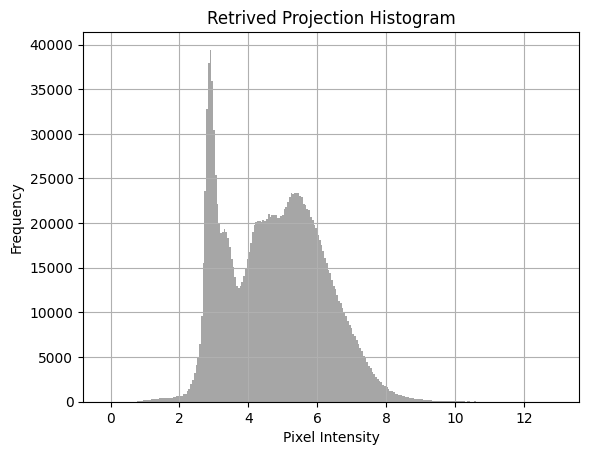

In [3]:
### Histogram
import matplotlib.pyplot as plt

def plot_histogram(image, title='Histogram', bins=256, range=None):
    """
    Plot the histogram of an image.

    Parameters:
    - image: 2D numpy array representing the image.
    - title: Title of the histogram plot.
    - bins: Number of bins for the histogram.
    - range: Range of values to consider for the histogram.

    Returns:
    - None
    """
    plt.hist(image.ravel(), bins=bins, range=range, color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()


plot_histogram(retrieved_projs[0], title='Retrived Projection Histogram', bins=256)

In [24]:

### Retrieve the sinogram

from joblib import Parallel, delayed
from tqdm import tqdm
import gc
import napari

import numpy as np

def apply_left_weighting(projs, CoR):
    """
    Applique un poids linéaire sur la partie gauche des projections.
    """
    weights = np.linspace(0, 1, CoR)[None, None, :] 

    projs[:, :, :CoR] *= weights

    return projs 
   

def create_sinogram_slice(projs, CoR, slice_idx):
    """
    Create a sinogram from a set of projections.
    """
    theta, nx, ny = projs.shape

    sino = np.zeros((theta//2, 2 * ny - CoR))

    flip = projs[:theta // 2, slice_idx, ::-1]  # np.flip optimisé
    
    sino[:, :ny] += flip
    sino[:,  -ny:] += projs[theta//2:, slice_idx, :]

    return sino

def create_sinogram(projs, CoR):
    """
    Create sinograms from a set of projections.
    """

    projs_weighted = apply_left_weighting(projs, CoR)

    sinos = np.array(
        Parallel(n_jobs=-1, backend='threading')(
            delayed(create_sinogram_slice)(projs_weighted, CoR, slice_idx)
            for slice_idx in tqdm(range(projs.shape[1]), desc='Creating sinograms')
        )
    )

    return sinos

CoR = 95.5
sinogram = create_sinogram(retrieved_projs, round(2*CoR))
print("Sinogram shape:", sinogram.shape)

import numpy as np
from numpy import pi

def from_degress_to_radians(angles):
    return angles * pi / 180

def from_radians_to_degrees(angles):
    return angles * 180 / pi

# angles = from_degress_to_radians(np.linspace(0, (sinogram.shape[1] - 1) * angle_padding, sinogram.shape[1], endpoint=False))
angles = np.linspace(0, pi, sinogram.shape[1], endpoint=False)

print("Angles shape:", angles)

### Reconstruction

from skimage.draw import disk
import astra

def reconstruct_from_sinogram_slice(sinogram, angles):
    """
    Reconstruct a 2D image from a sinogram using FBP_CUDA algorithm from ASTRA Toolbox.

    Parameters:
    - sinogram: 2D numpy array (angles, detectors) containing the sinogram.
    - angles: 1D numpy array of rotation angles (in radians).

    Returns:
    - reconstruction: 2D numpy array representing the reconstructed image.
    """

    # Définition des géométries de projection et du volume
    proj_geom = astra.create_proj_geom('parallel', 1.0, sinogram.shape[1], angles)
    vol_geom = astra.create_vol_geom(sinogram.shape[1], sinogram.shape[1])

    # Création des objets de données pour le sinogramme et la reconstruction
    sinogram_id = astra.data2d.create('-sino', proj_geom, sinogram)
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Configuration et exécution de l'algorithme FBP_CUDA
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id

    alg_id = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id)

    # Récupération et retour de la reconstruction
    reconstruction = astra.data2d.get(rec_id)

    # Libération des ressources ASTRA
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)

    return reconstruction

disk_mask = np.zeros((sinogram.shape[2], sinogram.shape[2]))
rr, cc = disk((sinogram.shape[2]//2, sinogram.shape[2]//2), sinogram.shape[2] // 2)
disk_mask[rr, cc] = 1

from tqdm import tqdm
import napari

# reconstruction = np.zeros((sinogram.shape[0], sinogram.shape[2], sinogram.shape[2]))
# for i in tqdm(range(sinogram.shape[0]), desc='Reconstructing'):
#     reconstruction[i] = reconstruct_from_sinogram_slice(sinogram[i], angles) * disk_mask

reconstruction = reconstruct_from_sinogram_slice(sinogram[459], angles) * disk_mask

print("Reconstruction shape:", reconstruction.shape)

print('SNR:', compute_snr(reconstruction))

viewer = napari.Viewer()
viewer.add_image(sinogram, name='Reconstruction')


Creating sinograms: 100%|██████████| 1200/1200 [00:06<00:00, 196.24it/s]


Sinogram shape: (1200, 1600, 2753)
Angles shape: [0.00000000e+00 1.96349541e-03 3.92699082e-03 ... 3.13570217e+00
 3.13766566e+00 3.13962916e+00]
Reconstruction shape: (2753, 2753)
SNR: 0.3296212037024599


<Image layer 'Reconstruction' at 0x1c65216f080>

In [25]:
viewer = napari.Viewer()
viewer.add_image(reconstruction, name='Reconstruction', colormap='gray')

<Image layer 'Reconstruction' at 0x1b6204f8dd0>

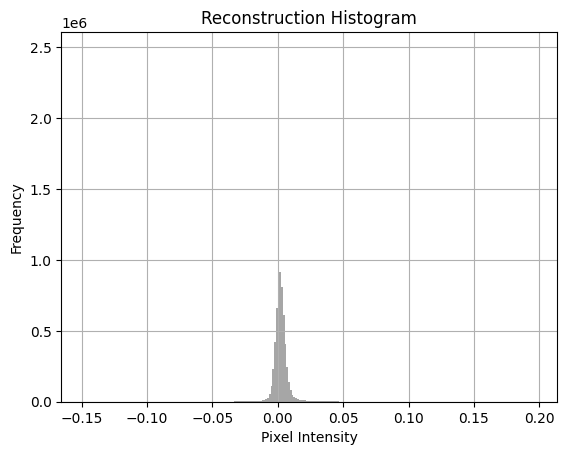

In [5]:
### Histogram
import matplotlib.pyplot as plt

def plot_histogram(image, title='Histogram', bins=256, range=None):
    """
    Plot the histogram of an image.

    Parameters:
    - image: 2D numpy array representing the image.
    - title: Title of the histogram plot.
    - bins: Number of bins for the histogram.
    - range: Range of values to consider for the histogram.

    Returns:
    - None
    """
    plt.hist(image.ravel(), bins=bins, range=range, color='gray', alpha=0.7)
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()


plot_histogram(reconstruction, title='Reconstruction Histogram', bins=256)

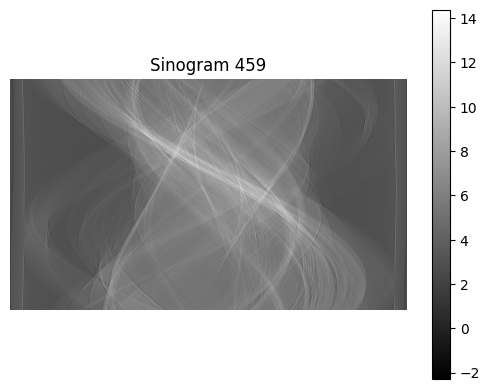

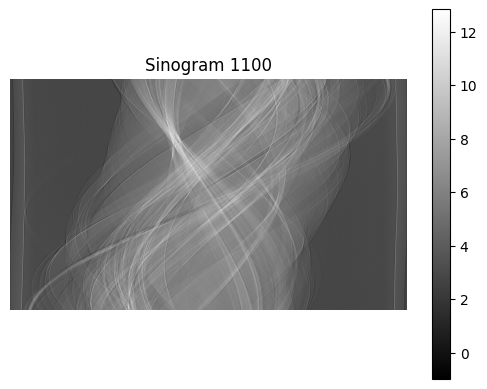

In [7]:
img1 = sinogram[459]
img2 = sinogram[1100]

display_slice(img1, title='Sinogram 459', cmap='gray', colorbar=True)
display_slice(img2, title='Sinogram 1100', cmap='gray', colorbar=True)

In [8]:
def get_std(img):
    return cp.std(cp.array(img))

def get_cv(img):
    return cp.std(cp.array(img)) / cp.mean(cp.array(img))

def compute_snr(img):

    signal = cp.asarray(img)
    noise = signal - cp.mean(signal)

    signal_power = cp.mean(signal ** 2)
    noise_power = cp.mean(noise ** 2)

    if noise_power == 0:
        return cp.inf
    return 10 * cp.log10(signal_power / noise_power)

def get_inv_snr(img):
    return 1 / compute_snr(cp.asarray(img))

print('Standarsd deviation info:', get_std(img1))
print('Standarsd deviation empty:', get_std(img2))
print('________________________________________________________')

print('Coefficient of variation info:', get_cv(img1))
print('Coefficient of variation empty:', get_cv(img2))
print('________________________________________________________')

print('SNR info:', compute_snr(img1))
print('SNR empty:', compute_snr(img2))
print('________________________________________________________')

print('Inverse SNR info:', get_inv_snr(img1))
print('Inverse SNR empty:', get_inv_snr(img2))
print('________________________________________________________')



Standarsd deviation info: 1.6996771408040328
Standarsd deviation empty: 1.733555545930401
________________________________________________________
Coefficient of variation info: 0.348273805896163
Coefficient of variation empty: 0.36359709900361603
________________________________________________________
SNR info: 9.658781239256133
SNR empty: 9.32683424915974
________________________________________________________
Inverse SNR info: 0.1035327310174192
Inverse SNR empty: 0.10721751596369268
________________________________________________________


In [9]:
std = []
cv = []
snr = []
inv_snr = []

for i in tqdm(range(sinogram.shape[0]), desc='Computing standard deviation'):
    std.append(get_std(sinogram[i]).get())
    cv.append(get_cv(sinogram[i]).get())
    snr.append(compute_snr(sinogram[i]).get())
    inv_snr.append(get_inv_snr(sinogram[i]).get())

Computing standard deviation: 100%|██████████| 1200/1200 [01:02<00:00, 19.16it/s]


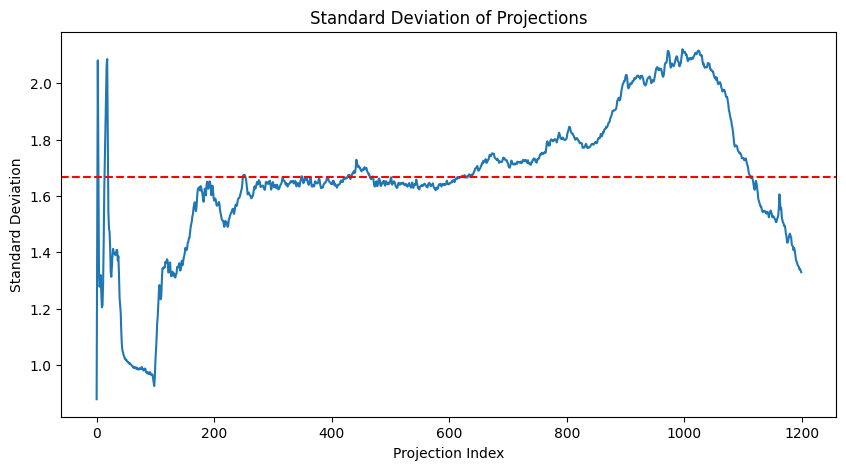

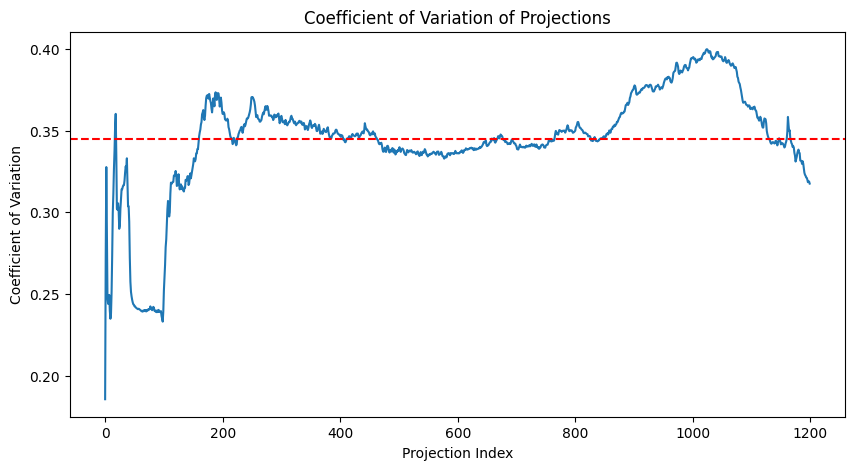

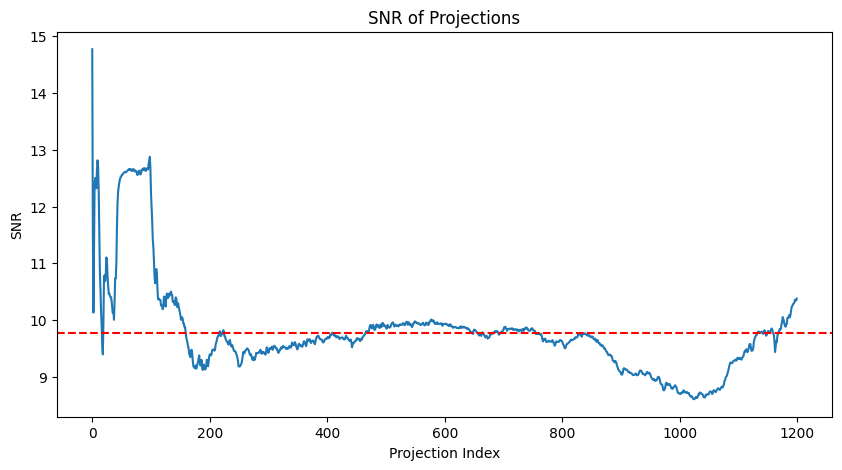

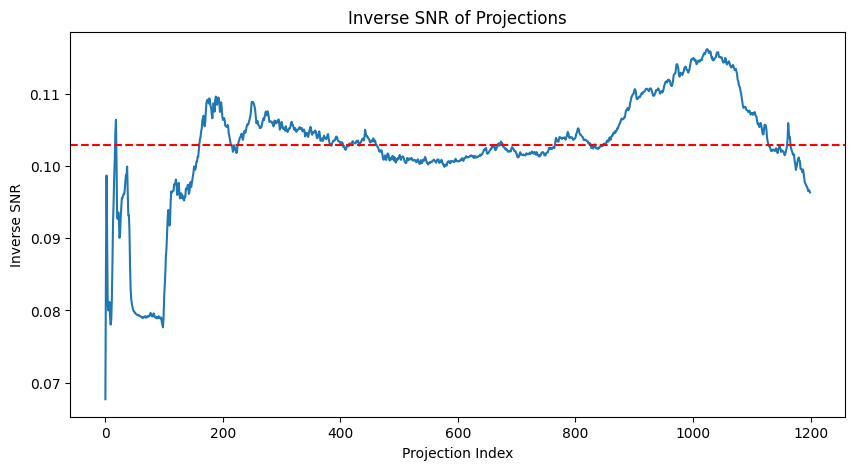

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(std, label='Standard Deviation')
plt.xlabel('Projection Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Projections')
plt.axhline(y=np.mean(std), color='r', linestyle='--', label='Mean')

plt.figure(figsize=(10, 5))
plt.plot(cv, label='Coefficient of Variation')
plt.xlabel('Projection Index')
plt.ylabel('Coefficient of Variation')
plt.title('Coefficient of Variation of Projections')
plt.axhline(y=np.mean(cv), color='r', linestyle='--', label='Mean')

plt.figure(figsize=(10, 5))
plt.plot(snr, label='SNR')
plt.xlabel('Projection Index')
plt.ylabel('SNR')
plt.title('SNR of Projections')
plt.axhline(y=np.mean(snr), color='r', linestyle='--', label='Mean')

plt.figure(figsize=(10, 5))
plt.plot(inv_snr, label='Inverse SNR')
plt.xlabel('Projection Index')
plt.ylabel('Inverse SNR')
plt.title('Inverse SNR of Projections')
plt.axhline(y=np.mean(inv_snr), color='r', linestyle='--', label='Mean')

Recherche du COR par ligne: 100%|██████████| 1200/1200 [05:12<00:00,  3.84it/s]


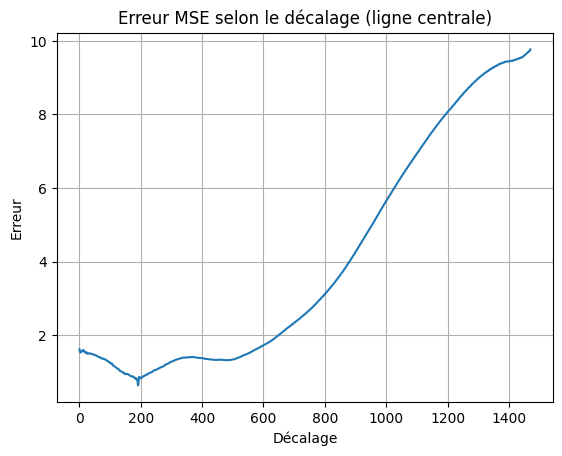

Centre estimé (ligne centrale) : 95.50 px
Centre moyen sur toutes les lignes : 95.56 px


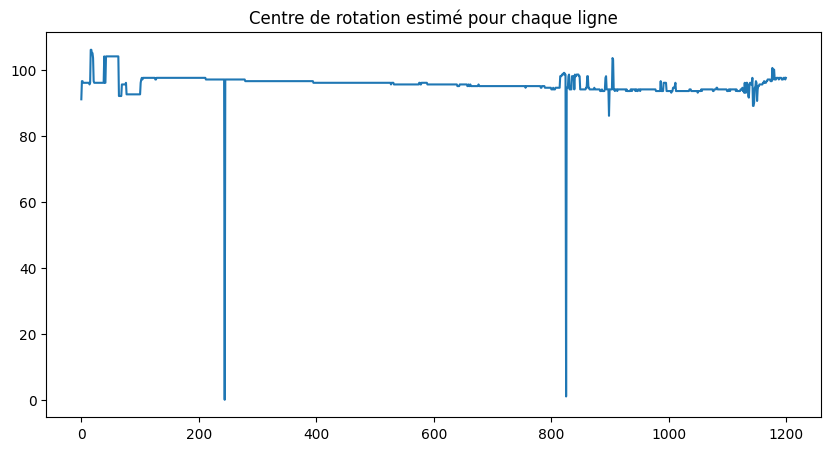

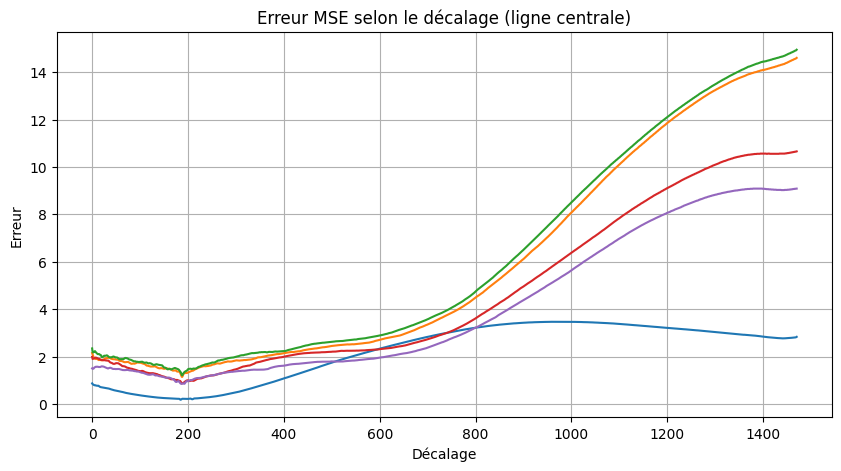

In [15]:
from numpy import random
import cupy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def calc_cor_gpu(projs):
    """
    projs_cp: projections [angles, hauteur, largeur] (CuPy array)
    """
    theta, ny, nx = projs.shape
    start = 0
    stop = ny
    step = 1
    cor = cp.zeros((stop - start + step - 1) // step, dtype=cp.float16)  # Stocke les centres pour chaque ligne
    plot_data = []

    i = 0
    for y in tqdm(range(start, stop, step), desc="Recherche du COR par ligne"):
        # sinogramme d'une ligne horizontale
        sino1 = cp.asarray(projs[:theta // 2, y, ::-1])  # Première moitié inversée
        sino2 = cp.asarray(projs[theta // 2:, y, :])     # Deuxième moitié

        errors = cp.zeros(nx - 1, dtype=cp.float16)  # Stocke les erreurs pour chaque décalage
        for shift in range(1, nx):
            t1 = sino1[:, -shift:]
            t2 = sino2[:, :shift]
            if t1.shape != t2.shape:
                continue
            mse = cp.mean((t1 - t2) ** 2)
            errors[shift - 1] = mse

        best_shift = cp.argmin(errors)
        plot_data.append(errors.get())  # Convertit en NumPy pour le traçage
        cor[i] = (best_shift) / 2  # Position estimée du COR
        i += 1

    return cor.get(), plot_data  # Convertit `cor` en NumPy pour l'utilisation ultérieure

cor, plot = calc_cor_gpu(retrieved_projs)
# Affichage des résultats
plt.plot(plot[len(plot) // 2])  # Trace les erreurs pour la ligne centrale
plt.title("Erreur MSE selon le décalage (ligne centrale)")
plt.xlabel("Décalage")
plt.ylabel("Erreur")
plt.grid(True)
plt.show()

print(f"Centre estimé (ligne centrale) : {cor[len(cor) // 2]:.2f} px")
print(f"Centre moyen sur toutes les lignes : {np.mean(cor):.2f} px")

plt.figure(figsize=(10, 5))
plt.plot(cor)
plt.title("Centre de rotation estimé pour chaque ligne")

plt.figure(figsize=(10, 5))
list = random.choice(range(len(plot)), 5)
for i in list:
    plt.plot(plot[i])
plt.title("Erreur MSE selon le décalage (ligne centrale)")
plt.xlabel("Décalage")
plt.ylabel("Erreur")
plt.grid(True)
plt.show()

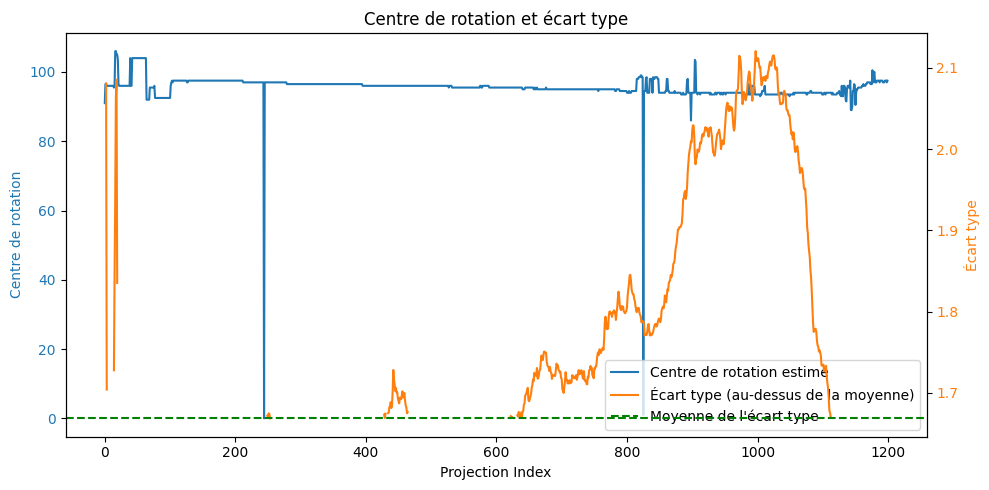

In [20]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 5))

# Centre de rotation
ax1.plot(cor, color='tab:blue', label='Centre de rotation estimé')
ax1.set_ylabel("Centre de rotation", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Deuxième axe Y pour std
ax2 = ax1.twinx()

# Masquage des valeurs en dessous ou égales à la moyenne
std_above_mean = np.where(std > np.mean(std), std, np.nan)

# Tracé seulement des valeurs au-dessus de la moyenne
ax2.plot(std_above_mean, color='tab:orange', label="Écart type (au-dessus de la moyenne)")
ax2.axhline(y=np.mean(std), color='green', linestyle='--', label="Moyenne de l'écart type")
ax2.set_ylabel("Écart type", color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Axe X et titre
ax1.set_xlabel("Projection Index")
plt.title("Centre de rotation et écart type")

# Fusion des légendes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

plt.tight_layout()
plt.show()


In [21]:
# Filtrage des indices où std est supérieur à sa moyenne
mask = std > np.mean(std)

# Calcul de la moyenne de cor seulement pour ces indices
mean_cor_filtered = np.mean(cor[mask])
print("Moyenne du centre de rotation (pour std > moyenne) :", mean_cor_filtered)


Moyenne du centre de rotation (pour std > moyenne) : 94.6


In [ ]:
### Trace une Gaussian de deux amplitudes differentes

import matplotlib.pyplot as plt
